In [1]:
import numpy as np
import statsmodels.api as sm

 
from ISLP import load_data
from ISLP import confusion_table
from ISLP.models import (ModelSpec as MS, summarize)

from sklearn.discriminant_analysis import  (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
Weekly = load_data('Weekly')

In [3]:
# (a)

Weekly.corr(numeric_only = True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


<Axes: >

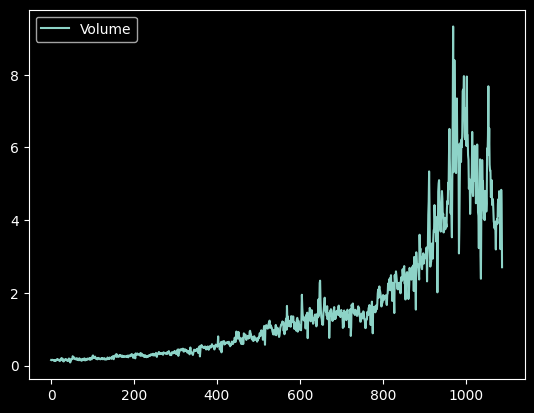

In [4]:
# (a)

Weekly.plot(y='Volume')

In [5]:
# (b)

def b():
    allvars = Weekly.columns.drop(['Today', 'Direction', 'Year'])
    design = MS(allvars)
    X = design.fit_transform(Weekly)
    y = Weekly.Direction == 'Up'
    glm = sm.GLM(y, X, family=sm.families.Binomial())
    results = glm.fit()
    print(summarize(results))
    return results.predict()

temp_probs = b()

# Lag2 is a statistically significant predictor: p-value = 0.03 < 0.05

             coef  std err      z  P>|z|
intercept  0.2669    0.086  3.106  0.002
Lag1      -0.0413    0.026 -1.563  0.118
Lag2       0.0584    0.027  2.175  0.030
Lag3      -0.0161    0.027 -0.602  0.547
Lag4      -0.0278    0.026 -1.050  0.294
Lag5      -0.0145    0.026 -0.549  0.583
Volume    -0.0227    0.037 -0.616  0.538


In [6]:
# (c - confusion table)

labels_all = np.array(['Down'] * len(Weekly))
labels_all[temp_probs>0.5] = "Up"


confusion_table(labels_all, Weekly.Direction)

# The diagonal elements of the confusion matrix indicate correct predictions, while the off-diagonals represent incorrect predictions. 
# Hence our model correctly predicted that the market would go up on 557 days and that it would go down on 54 days, 
# for a total of 54 + 557 = 611 correct predictions.

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [7]:
# (c - average)

#  the fraction of days for which the prediction was correct.
np.mean(labels_all == Weekly.Direction)

0.5610651974288338

In [8]:
# (d -  confusion matrix)
train = (Weekly.Year < 2009)

D = Weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]

model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
y = Weekly.Direction == 'Up'
y_train, y_test = y.loc[train], y.loc[~train]
X_train, X_test = X.loc[train], X.loc[~train]
# fit using train data
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
# predict using test data
probs_test = results.predict(exog=X_test)
labels_test = np.array(['Down'] * len(probs_test))
labels_test[probs_test>0.5] = 'Up'

confusion_table(labels_test, L_test)


Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [9]:
# (d -  overall fraction of correct predictions for the held out data)

np.mean(labels_test == L_test)

0.625

In [10]:
# (e -  confusion table)

lda = LDA(store_covariance=True)
lda.fit(X_train, L_train)
lda_pred = lda.predict(X_test)

confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [11]:
# (e - fraction of correct predictions)

np.mean(lda_pred == L_test)

0.625

In [12]:
# (f - confusion table)

qda = QDA(store_covariance=True) 
qda.fit(X_train, L_train)
qda_pred = qda.predict(X_test)

confusion_table(qda_pred, L_test)

c:\Users\User\Documents\afeka\msc-assignments\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\User\Documents\afeka\msc-assignments\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\User\Documents\afeka\msc-assignments\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1052: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\User\Documents\afeka\msc-assignments\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1052: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\User\Documents\afeka\msc-assignments\.ven

Truth,Down,Up
Predicted,,
Down,43,61
Up,0,0


In [13]:
# (f - fraction of correct predictions)

np.mean(qda_pred == L_test)

0.41346153846153844

In [14]:
# (g - confusion table)

knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)

confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,22,31
Up,21,30


In [15]:
# (g - fraction of correct predictions)

np.mean(knn1_pred == L_test)

0.5

In [16]:
# (h - confusion table)

nb = GaussianNB()
nb.fit(X_train, L_train)
nb_labels = nb.predict(X_test)

confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [17]:
# (h - fraction...)

np.mean(nb_labels == L_test)

0.5865384615384616

i - Which of these methods appears to provide the best results on this data?

Logistic regressioin and the LDA has the succes rate - 62.5%

In [18]:
# (j)

for n_n in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=n_n)
    knn.fit(X_train, L_train)
    knn_pred = knn.predict(X_test)
    success_rate = np.mean(knn_pred == L_test)
    print('neighbors: {0:4}, success rate: {1}'.format(n_n, success_rate))

# best rate if 61.5% for 47 neighbors


neighbors:    1, success rate: 0.5
neighbors:    2, success rate: 0.47115384615384615
neighbors:    3, success rate: 0.5480769230769231
neighbors:    4, success rate: 0.5769230769230769
neighbors:    5, success rate: 0.5384615384615384
neighbors:    6, success rate: 0.5096153846153846
neighbors:    7, success rate: 0.5480769230769231
neighbors:    8, success rate: 0.5576923076923077
neighbors:    9, success rate: 0.5480769230769231
neighbors:   10, success rate: 0.5673076923076923
neighbors:   11, success rate: 0.5576923076923077
neighbors:   12, success rate: 0.5673076923076923
neighbors:   13, success rate: 0.5865384615384616
neighbors:   14, success rate: 0.5673076923076923
neighbors:   15, success rate: 0.5865384615384616
neighbors:   16, success rate: 0.5769230769230769
neighbors:   17, success rate: 0.5865384615384616
neighbors:   18, success rate: 0.5865384615384616
neighbors:   19, success rate: 0.5673076923076923
neighbors:   20, success rate: 0.5961538461538461
neighbors:   2